In [1]:
import os
import warnings
import torchvision.datasets as dset

from transformers import logging
from torch.utils.data import DataLoader

from encoder_models import *
from loss_functions import *
from utils_clip import *
from hooks import *

from tqdm import tqdm

logging.set_verbosity_error()
warnings.filterwarnings("ignore")

# Inits

In [2]:
checkpoint_path ='/cephyr/NOBACKUP/groups/naiss2024-6-186/nikos/modelSave/model_epoch_30.pt' 
vit_trans_name = 'google/vit-base-patch16-224'
bert_model_name = 'bert-base-uncased'
embed_dim = 128 ## make this dynamic

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print (f'Using: {device}')

coco_dataset_tst = dset.CocoCaptions(
    root='/cephyr/NOBACKUP/groups/naiss2024-6-186/nikos/test2017',
    annFile='/cephyr/NOBACKUP/groups/naiss2024-6-186/nikos/image_info_test2017.json'
)

test_dataset = CocoCaptionDataset(coco_dataset_tst, mode="test")

# instantiate
encoder_1 = Transformer_One(vit_trans_name, embed_dim, device=device)
encoder_2 = Transformer_Two(bert_model_name, embed_dim, device=device)
# load
encoder_1, encoder_2, opt_state_dct, loss_state_dct, epoch_load, tr_loss, vld_loss = load_model(checkpoint_path, encoder_1, encoder_2, device)
logit_sc = loss_state_dct['logit_scale'].exp() ## logit scale
# place
encoder_1.to(device)
encoder_2.to(device)

dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False, drop_last=False, num_workers=16)

Using: cuda:0
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


# Precompute Image embeddings

In [3]:
save_path = '/mimer/NOBACKUP/groups/snic2022-6-127/nikos/ViTClip/coco/test/img/'
pt_files = [f for f in os.listdir(save_path) if f.endswith('.pt')]

if not pt_files:
    precompute_img_emb(encoder_1, dataloader, save_path)

im_em = load_embeddings(save_path)
assert im_em.shape[0] == len(test_dataset), "Dimension mismatch!"
print (im_em.shape)

test_set_img_5.pt
test_set_img_10.pt
test_set_img_15.pt
test_set_img_20.pt
test_set_img_25.pt
test_set_img_30.pt
test_set_img_35.pt
test_set_img_40.pt
test_set_img_42.pt
torch.Size([40670, 128])


# Precompute text embeddings (classes) and plot

Total classes: 80


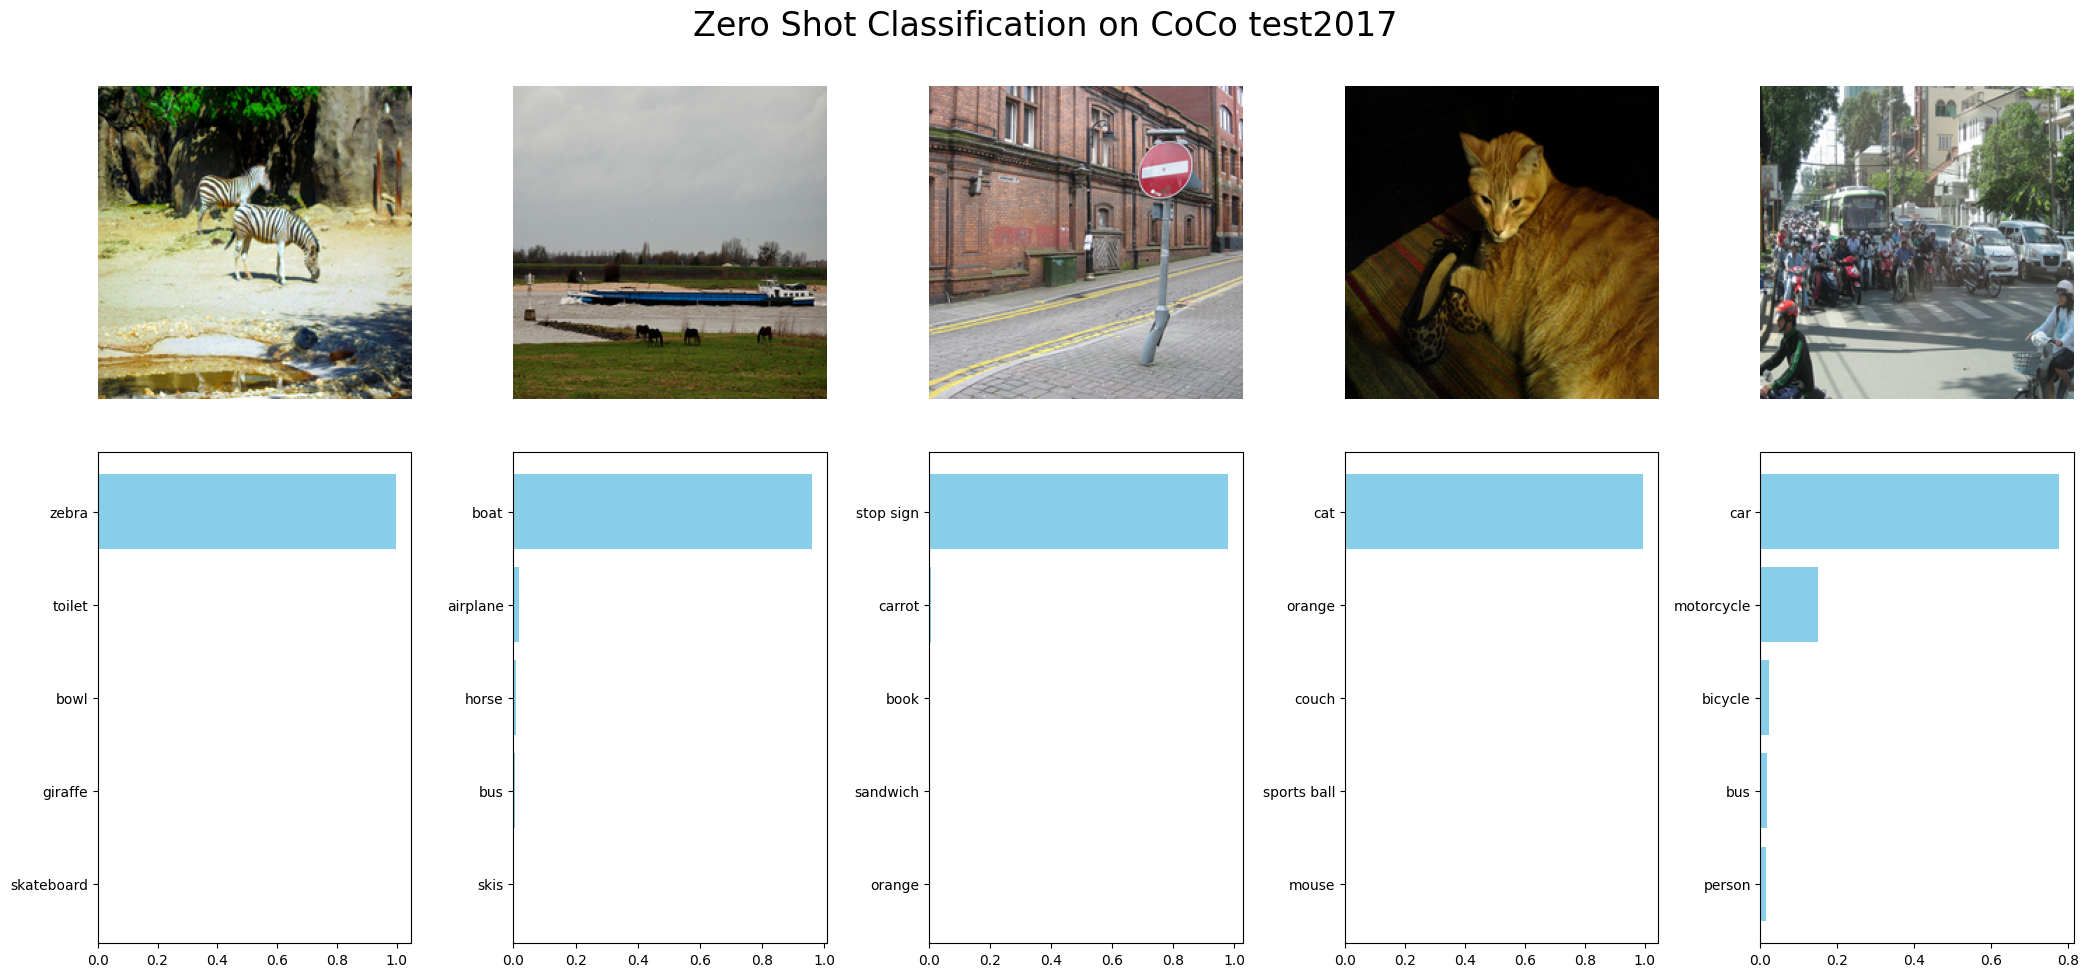

In [4]:
path = 'coco_classes.txt'
class_embed, classes = precompute_class_emb(encoder_2, path)

# take 5 random pictures and their embs
random_images = torch.randint(0, len(test_dataset), (5,))
query_images = im_em[random_images]

im_plt = []
txt_plt = []
probs = []

for i in range(len(query_images)):
    top_idxs, sims = find_top_k_matches(class_embed, query_images[i].unsqueeze(0), logit_sc, k=5, device=device)
    this_image, _ = coco_dataset_tst[random_images[i]]
    relevant_txt = [classes[idx.item()] for idx in top_idxs]
    im_plt.append(this_image)
    txt_plt.append(relevant_txt)
    probs.append(sims)

plot_images_and_bars(im_plt, txt_plt, probs)